We load the dataset using the function given and import the needed packages.

In [16]:
import numpy as np
from urllib.request import urlopen
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784) # besides loadng 
                                                                                            #the data, I already flatten it into a vector
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

In [2]:
X_train, Y_train, X_test, Y_test = load_fashion_mnist() # you can use this function (copying the whole box) in your code to easily load the data
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(60000, 784) (60000,) (10000, 784) (10000,)


We plot random image of different classes.

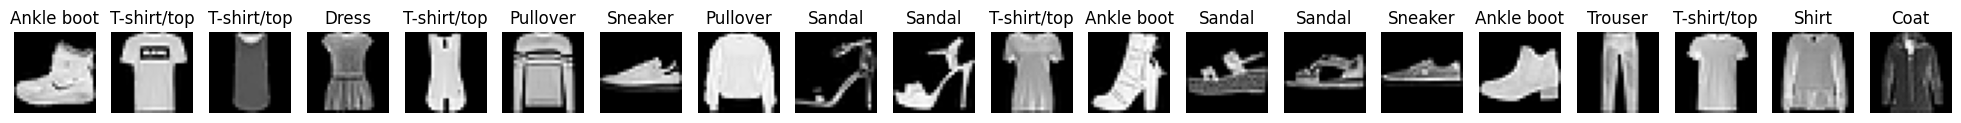

In [3]:
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = X_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[Y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

To better work on the data we divide validation and train sets and we convert them into pandas dataframes to then we check for missing values.

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=10000, train_size=50000, random_state=1)
      
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

print(X_train_df.isna().sum().sum())
print(X_test_df.isna().sum().sum())


0
0


In [5]:
print(X_train_df.head())
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    0    0    0    0    0    0    0    0    0    0  ...   91  103  103  103   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   778  779  780  781  782  783  
0   72    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 784 columns]
(50000, 784) (50000,) (10000, 784) (10000,) (10000, 784) (10000,)


We normalize our data using the parameters fitted on the train set

In [6]:
scaler = MinMaxScaler()
X_train2 = scaler.fit_transform(X_train)
X_val2 = scaler.transform(X_val)
X_test2 = scaler.transform(X_test)

we apply PCA on our data to reduce dimensionality and noise while keeping the majority of information intact

In [7]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train2)
X_val_pca = pca.transform(X_val2)
X_test_pca = pca.transform(X_test2)

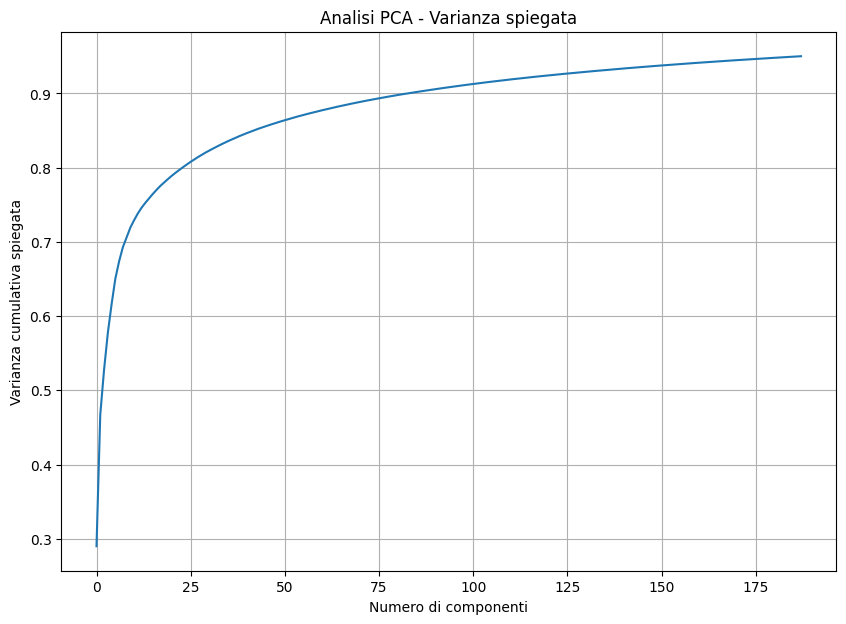

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza cumulativa spiegata')
plt.title('Analisi PCA - Varianza spiegata')
plt.grid(True)
plt.show()


In [9]:
print(f'Train set new dimensions: {X_train_pca.shape}')
print(f'Validation set new dimensions: {X_val_pca.shape}')
print(f'Test set new dimensions: {X_test_pca.shape}')

Train set new dimensions: (50000, 188)
Validation set new dimensions: (10000, 188)
Test set new dimensions: (10000, 188)


We check the frequency of classes across the dataset to see if they're balanced, which they are.

<Axes: >

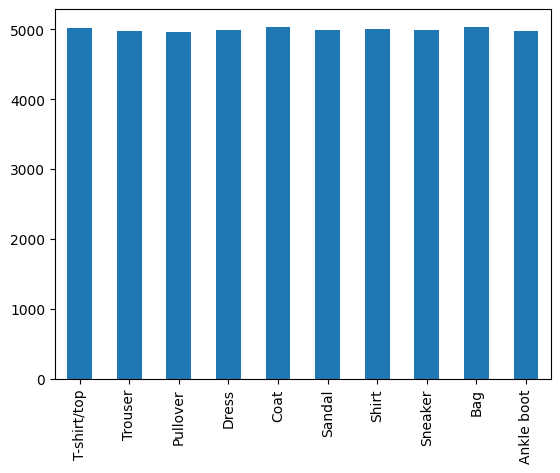

In [10]:
unique, counts = np.unique(Y_train, return_counts=True)
Y_class_fr = pd.DataFrame(counts, index = y_labels)
Y_class_fr = Y_class_fr.rename(columns={0: "Count"})
Y_class_fr.plot.bar(legend = False)

We define a neural network to classify the images:

first, we tansform our lables into one-hot encoded matrixes

In [11]:
num_classes = len(np.unique(Y_train))
Y_train_one_hot = to_categorical(Y_train, num_classes)
Y_val_one_hot = to_categorical(Y_val, num_classes)
Y_test_one_hot = to_categorical(Y_test, num_classes)

KNN implementation:

grid search for KNN hyperparameter

In [13]:
k_values = range(1, 31)

train_accuracies = []
validation_accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, Y_train)
    Y_train_pred = knn.predict(X_train_pca)
    Y_val_pred = knn.predict(X_val_pca)
    
    train_accuracies.append(accuracy_score(Y_train, Y_train_pred))
    validation_accuracies.append(accuracy_score(Y_val, Y_val_pred))



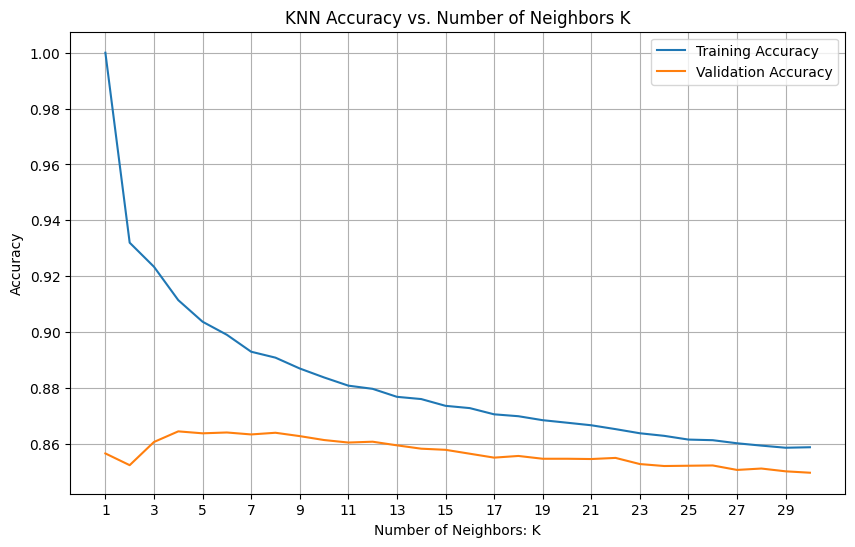

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Neighbors: K')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors K')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2.0))
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_pca, Y_train)
Y_test_pred = knn.predict(X_test_pca)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f"Accuracy on the test set with K=8: {test_accuracy}")

Accuracy on the test set with K=8: 0.8609


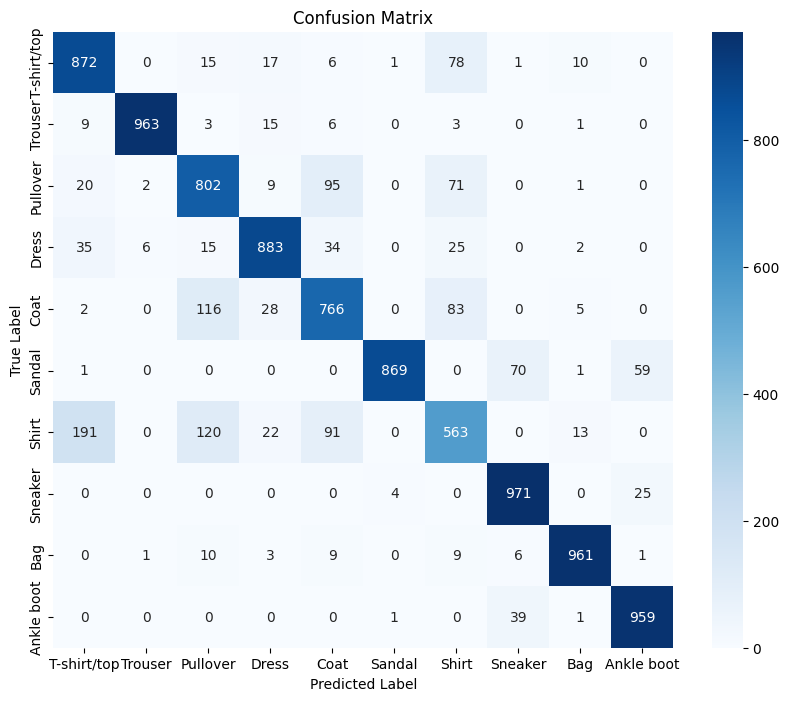

In [25]:
conf_matrix = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

SVC implementation

In [18]:
svc = SVC(kernel='linear')
param_grid = {'C': [0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', refit=True)
grid_search.fit(X_train_pca, Y_train)
print("Miglior parametro C trovato:", grid_search.best_params_)
print("Miglior score di validazione:", grid_search.best_score_)

In [ ]:
Y_test_pred = grid_search.predict(X_test_pca)
+
print("Valutazione sul set di test con il miglior C:")
print(classification_report(Y_test, Y_test_pred))
print("Accuracy sul set di test:", accuracy_score(Y_test, Y_test_pred))

Dense Neural Network:

We then define and train our neural network with adam optimizer, categorical_crossentropy as the loss function and an early stoppage to keep the best values.
(dropout layers are included to prevent overfitting, final optimized form of the model is shown)

In [14]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(188,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

history = model.fit(X_train_pca, Y_train_one_hot, validation_data=(X_val_pca, Y_val_one_hot),
                    epochs=75, batch_size=128, verbose=1,
                    callbacks=[early_stopping])


Epoch 1/75
391/391 [==============================] - 2s 4ms/step - loss: 0.8431 - accuracy: 0.7028 - val_loss: 0.4191 - val_accuracy: 0.8486
Epoch 2/75
391/391 [==============================] - 1s 3ms/step - loss: 0.4986 - accuracy: 0.8311 - val_loss: 0.3788 - val_accuracy: 0.8608
Epoch 3/75
391/391 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.8506 - val_loss: 0.3510 - val_accuracy: 0.8749
Epoch 4/75
391/391 [==============================] - 1s 3ms/step - loss: 0.4059 - accuracy: 0.8588 - val_loss: 0.3376 - val_accuracy: 0.8790
Epoch 5/75
391/391 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.8689 - val_loss: 0.3275 - val_accuracy: 0.8819
Epoch 6/75
391/391 [==============================] - 1s 3ms/step - loss: 0.3605 - accuracy: 0.8744 - val_loss: 0.3222 - val_accuracy: 0.8847
Epoch 7/75
391/391 [==============================] - 1s 3ms/step - loss: 0.3413 - accuracy: 0.8807 - val_loss: 0.3196 - val_accuracy: 0.8840
Epoch 

Accuracy and loss graphs, plus evaluation of the accuracy on the test set

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test scores:
313/313 - 0s - loss: 0.3113 - accuracy: 0.8922 - 337ms/epoch - 1ms/step
1563/1563 - 2s - loss: 0.1552 - accuracy: 0.9435 - 2s/epoch - 1ms/step


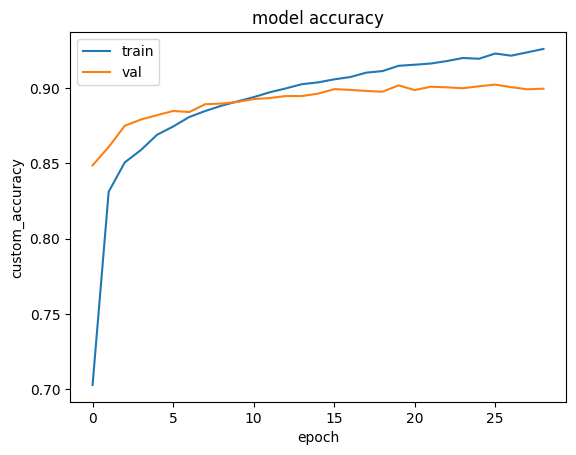

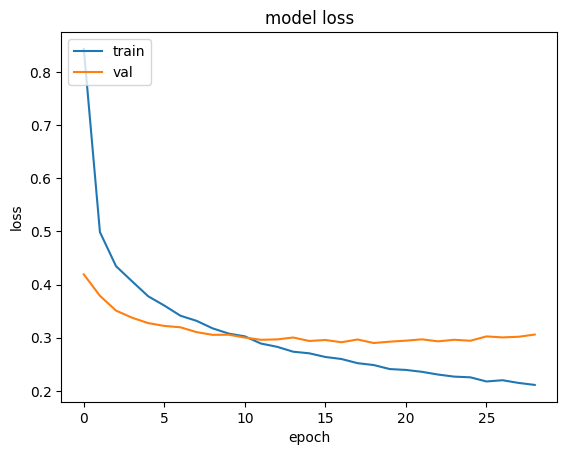

In [15]:
print(history.history.keys())
print('Test scores:')
test_loss, test_acc = model.evaluate(X_test_pca, Y_test_one_hot, verbose=2)
train_loss, train_acc = model.evaluate(X_train_pca, Y_train_one_hot, verbose=2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('custom_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

313/313 [==============================] - 0s 1ms/step


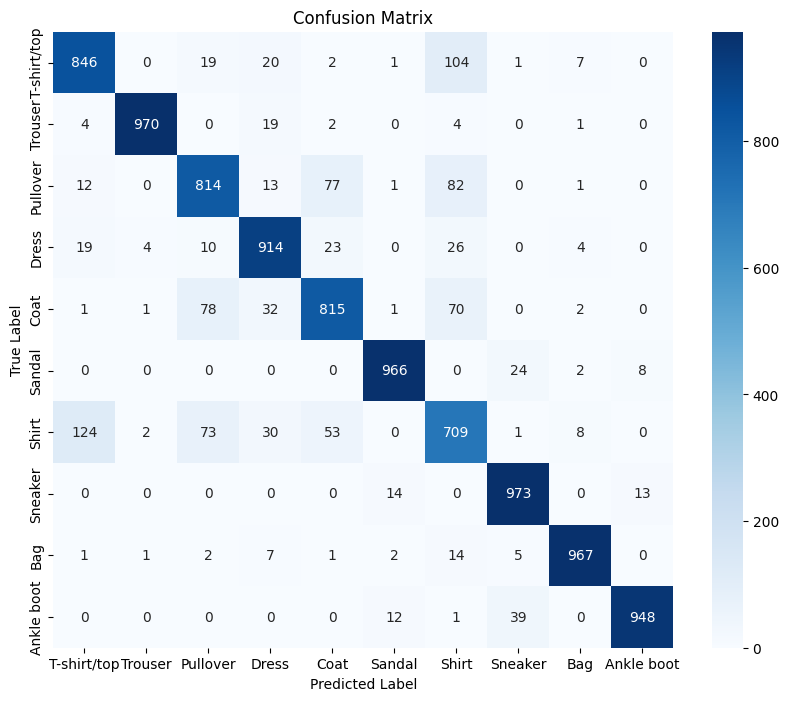

In [17]:
predictions = model.predict(X_test_pca)
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(Y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

CNN implementation:

to start, we reshape the data to be fed to the CNN.

In [26]:
X_train3 = X_train2.reshape((-1, 28, 28, 1))
X_val3 = X_val2.reshape((-1, 28, 28, 1))
X_test3 = X_test2.reshape((-1, 28, 28, 1))

We then define and train the CNN

In [27]:
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

history = model.fit(X_train3, Y_train_one_hot, validation_data=(X_val3, Y_val_one_hot), epochs=50, batch_size=128, callbacks=[early_stopping])

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 0.6733 - accuracy: 0.7607 - val_loss: 0.4031 - val_accuracy: 0.8494
Epoch 2/50
391/391 [==============================] - 7s 18ms/step - loss: 0.4196 - accuracy: 0.8505 - val_loss: 0.3469 - val_accuracy: 0.8718
Epoch 3/50
391/391 [==============================] - 7s 18ms/step - loss: 0.3667 - accuracy: 0.8696 - val_loss: 0.3165 - val_accuracy: 0.8765
Epoch 4/50
391/391 [==============================] - 7s 18ms/step - loss: 0.3342 - accuracy: 0.8799 - val_loss: 0.2887 - val_accuracy: 0.8939
Epoch 5/50
391/391 [==============================] - 7s 18ms/step - loss: 0.3095 - accuracy: 0.8874 - val_loss: 0.2772 - val_accuracy: 0.8979
Epoch 6/50
391/391 [==============================] - 7s 17ms/step - loss: 0.2897 - accuracy: 0.8951 - val_loss: 0.2635 - val_accuracy: 0.9021
Epoch 7/50
391/391 [==============================] - 7s 17ms/step - loss: 0.2746 - accuracy: 0.8990 - val_loss: 0.2657 - val_accuracy: 0.9039

CNN metrics evaluation and test accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
313/313 [==============================] - 1s 4ms/step - loss: 0.2500 - accuracy: 0.9127


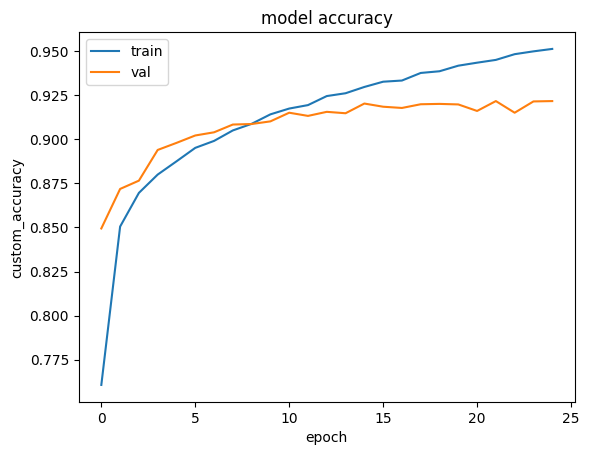

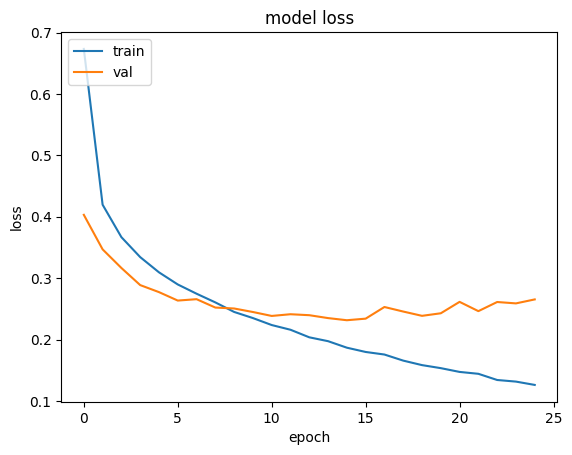

In [28]:
print(history.history.keys())
test_loss, test_accuracy = model.evaluate(X_test3, Y_test_one_hot)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('custom_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


313/313 [==============================] - 1s 4ms/step


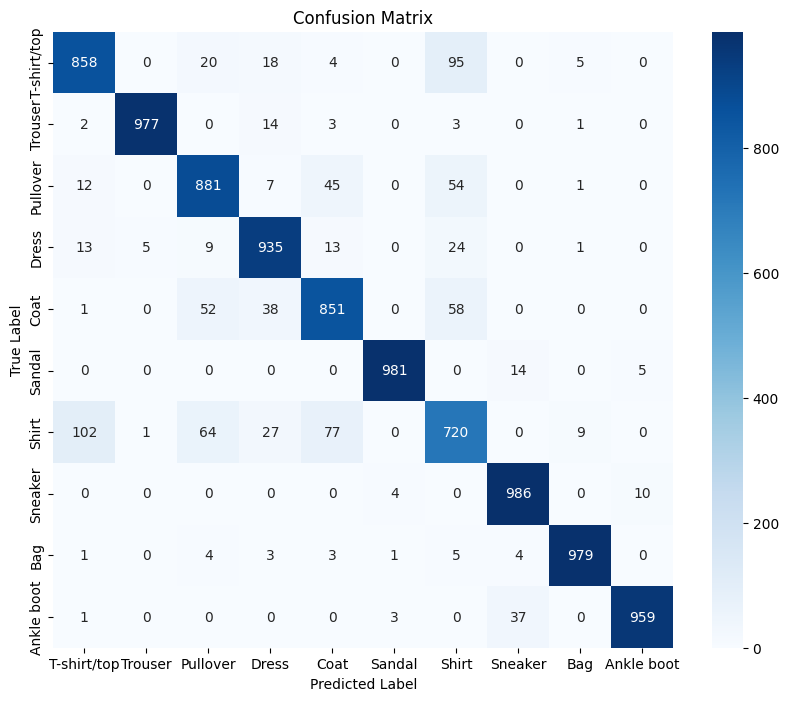

In [29]:
predictions = model.predict(X_test3)
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(Y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()